In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

import adi
from pysmu import Session, Mode

In [29]:
# Pluto SDR parameters
sample_rate = int(1e6) # Hz
tone_freq = int(1e3) # Hz
center_freq = int(2.45e9) - tone_freq # Hz
n_samples = 2**12 # number of samples returned per call to rx()/tx()

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = sample_rate
sdr.tx_rf_bandwidth = sample_rate # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = center_freq

sdr.gain_control_mode_chan0 = 'manual'
sdr.tx_hardwaregain_chan0 = -50 # Increase to increase tx power, valid range is -89 to 0 dB

sdr.tx_cyclic_buffer = True

In [3]:
# ADALM1000 ADC parameters 
session = Session()
if not session.devices:
    # no devices found
    print("No devices found!")
    sys.exit(1)

# single device operation
dev = session.devices[0]
# CH A voltage reader
chan_a = dev.channels['A']
chan_a.mode = Mode.HI_Z
# chan_b = dev.channels['B']
# chan_b.mode = Mode.HI_Z

In [5]:
# Disable WiFi, Bluetooth when measuring power in the 2.4-2.5GHz range

# Connect matched load do AD8317 board and measure standby voltage
# crude single point calibration
cal_samples = dev.get_samples(1e5)
samp_chan_a, samp_chan_b = zip(*cal_samples)
v_chan_a, i_chan_a = zip(*samp_chan_a)
standby_voltage = np.average(v_chan_a) # minimum of the power detector -60 dBm
min_psens_dbm = -60
v_slope_per_dbm = -0.022 # -22mV/dBm - slope provided by pcb manufacturer 

print("Standby voltage: %f V" %(standby_voltage))

Standby voltage: 1.534671 V


In [6]:
# Connect PLUTO TX to the AD8317 board directly to measure the power 
# waveform
t_lin = np.linspace(0, 1, num=n_samples)
tx_samples = np.exp(2j*np.pi*t_lin*tone_freq)
tx_samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14

v_avg_len = 1e4
gain_step = 1.0
tx_gain_lst = np.arange(-89.0, 0.1, gain_step)
ad8317_v = np.zeros(len(tx_gain_lst))

# measurement loop
for tx_gain_idx, tx_gain in enumerate(tx_gain_lst):
    sdr.tx_destroy_buffer()
    sdr.tx_hardwaregain_chan0 = tx_gain
    sdr.tx(tx_samples)
    
    adalm1000_samples = dev.get_samples(v_avg_len)
    samp_chan_a, samp_chan_b = zip(*adalm1000_samples)
    v_chan_a, i_chan_a = zip(*samp_chan_a)
    avg = np.average(v_chan_a)
    ad8317_v[tx_gain_idx] = np.average(avg)
    
sdr.tx_destroy_buffer()
print("Finished measurement!")

Finished measurement!


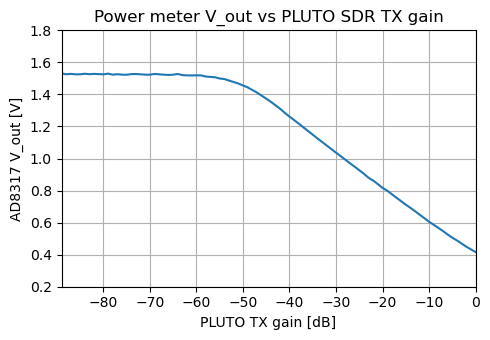

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5, 3.5))
ax.plot(tx_gain_lst, ad8317_v)
ax.set_xlim([-89.0, 0.0])
ax.set_ylim([0.2, 1.8])

ax.set_ylabel("AD8317 V_out [V]")
ax.set_xlabel("PLUTO TX gain [dB]")
ax.set_title("Power meter V_out vs PLUTO SDR TX gain")
ax.grid()
plt.tight_layout()
plt.savefig("results/ad8317_vout_vs_pluto_tx_gain_2_45GHz.png", dpi=600, bbox_inches='tight')
plt.show()

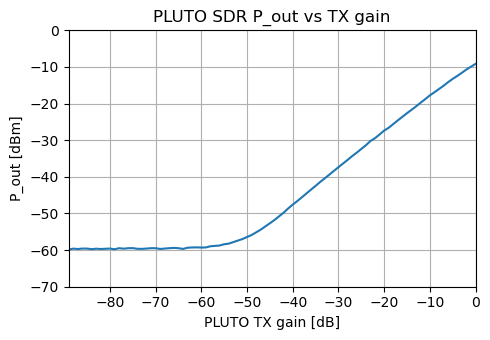

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5, 3.5))
ax.plot(tx_gain_lst, min_psens_dbm + (ad8317_v - standby_voltage) / v_slope_per_dbm)
ax.set_xlim([-89.0, 0.0])
ax.set_ylim([-70.0, 0.0])

ax.set_ylabel("P_out [dBm]")
ax.set_xlabel("PLUTO TX gain [dB]")
ax.set_title("PLUTO SDR P_out vs TX gain")
ax.grid()
plt.tight_layout()
plt.savefig("results/pluto_tx_pout_vs_tx_gain_2_45GHz.png", dpi=600, bbox_inches='tight')
plt.show()

In [12]:
# SKY65135  2.4-2.5 RF Power Amplifier 2.4GHZ 1W measurement
# 5 V power supply
# additional 30 dB attenuator mounted before AD8317

pa_att_db = 30
v_avg_len = 1e4
gain_step = 1.0
tx_gain_lst = np.arange(-89.0, 0.1, gain_step)
ad8317_pa_v = np.zeros(len(tx_gain_lst))

# measurement loop
for tx_gain_idx, tx_gain in enumerate(tx_gain_lst):
    sdr.tx_destroy_buffer()
    sdr.tx_hardwaregain_chan0 = tx_gain
    sdr.tx(tx_samples)
    
    adalm1000_samples = dev.get_samples(v_avg_len)
    samp_chan_a, samp_chan_b = zip(*adalm1000_samples)
    v_chan_a, i_chan_a = zip(*samp_chan_a)
    avg = np.average(v_chan_a)
    ad8317_pa_v[tx_gain_idx] = np.average(avg)
    
sdr.tx_destroy_buffer()
print("Finished measurement!")

Finished measurement!


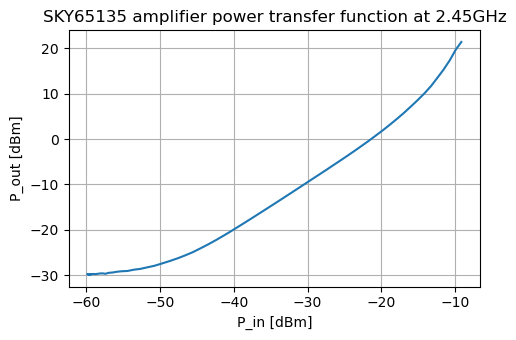

In [13]:
pin_dbm_lst = min_psens_dbm + (ad8317_v - standby_voltage) / v_slope_per_dbm
pout_dbm_lst = min_psens_dbm + (ad8317_pa_v - standby_voltage) / v_slope_per_dbm + pa_att_db

fig, ax = plt.subplots(1,1, figsize=(5, 3.5))
ax.plot(pin_dbm_lst, pout_dbm_lst)
# ax.set_xlim([-60.0, -10.0])
# ax.set_ylim([-52.5, -35])

ax.set_ylabel("P_out [dBm]")
ax.set_xlabel("P_in [dBm]")
ax.set_title("SKY65135 amplifier power transfer function at 2.45GHz")
ax.grid()
plt.tight_layout()
plt.savefig("results/sky65135_pout_vs_pin_2_45GHz.png", dpi=600, bbox_inches='tight')
plt.show()

In [30]:
# test other frequencies
ad8317_pa_v_per_freq_lst = []

freq_lst = [2400e6, 2450e6, 2500e6]
for center_freq in freq_lst:
    
    sdr.tx_lo = int(center_freq - tone_freq)
    v_avg_len = 1e4
    gain_step = 1.0
    tx_gain_lst = np.arange(-89.0, 0.1, gain_step)
    ad8317_pa_v = np.zeros(len(tx_gain_lst))

    # measurement loop
    for tx_gain_idx, tx_gain in enumerate(tx_gain_lst):
        sdr.tx_destroy_buffer()
        sdr.tx_hardwaregain_chan0 = tx_gain
        sdr.tx(tx_samples)

        adalm1000_samples = dev.get_samples(v_avg_len)
        samp_chan_a, samp_chan_b = zip(*adalm1000_samples)
        v_chan_a, i_chan_a = zip(*samp_chan_a)
        avg = np.average(v_chan_a)
        ad8317_pa_v[tx_gain_idx] = np.average(avg)
        
    ad8317_pa_v_per_freq_lst.append(ad8317_pa_v)
    sdr.tx_destroy_buffer()
print("Finished measurement!")

Finished measurement!


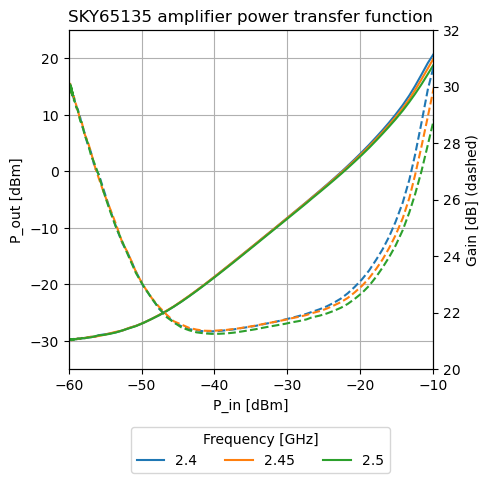

In [38]:
fig, ax1 = plt.subplots(1,1, figsize=(5, 5))
ax2 = ax1.twinx()
pin_dbm_lst = min_psens_dbm + (ad8317_v - standby_voltage) / v_slope_per_dbm
for tone_idx, tone_freq in enumerate(freq_lst):
    pout_per_freq_dbm_lst = min_psens_dbm + (ad8317_pa_v_per_freq_lst[tone_idx] - standby_voltage) / v_slope_per_dbm + pa_att_db
    ax1.plot(pin_dbm_lst, pout_per_freq_dbm_lst, label=tone_freq / 1e9, linestyle="-")
    ax2.plot(pin_dbm_lst, pout_per_freq_dbm_lst - pin_dbm_lst, label=tone_freq / 1e9, linestyle="--")
    
ax2.set_xlim([-60.0, -10.0])
ax2.set_ylim([20, 32])
ax2.set_ylabel("Gain [dB] (dashed)")

ax1.set_xlim([-60.0, -10.0])
ax1.set_ylim([-35.0, 25.0])
ax1.set_ylabel("P_out [dBm]")
ax1.set_xlabel("P_in [dBm]")
ax1.set_title("SKY65135 amplifier power transfer function")
ax1.grid()
ax1.legend(title="Frequency [GHz]", ncol=3, bbox_to_anchor=(0.9, -0.15))

plt.tight_layout()
plt.savefig("results/sky65135_pout_vs_pin_%sMHz.png" %('_'.join([str(int(val / 1e6)) for val in freq_lst])), dpi=600, bbox_inches='tight')
plt.show()

# Testbed setup
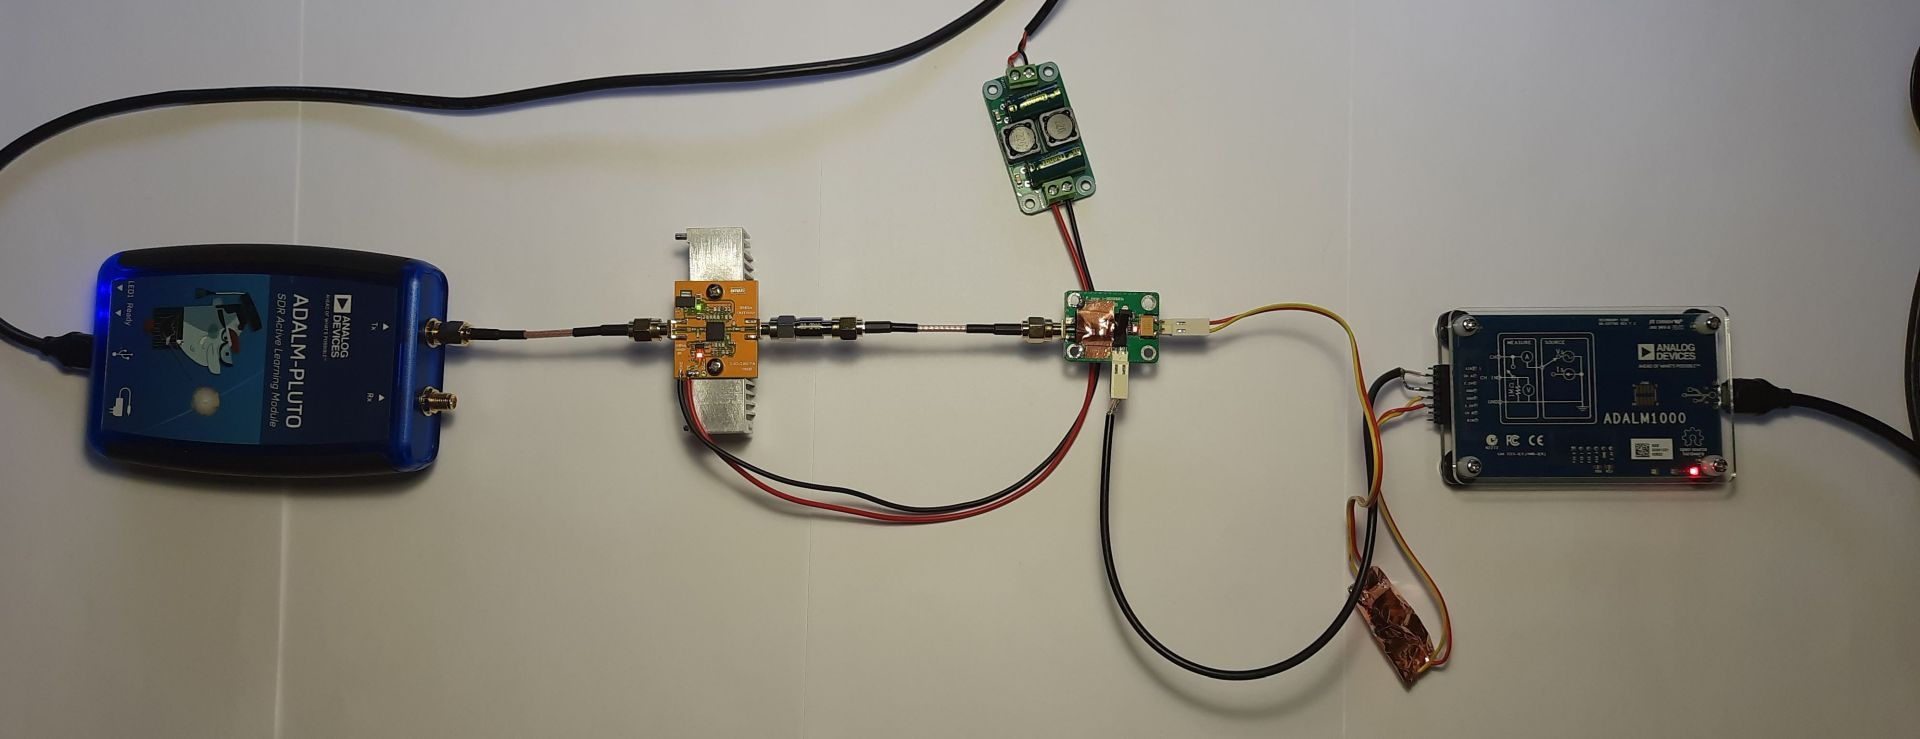